<b> Data: </b>

The train and test data will consist of various features that describe that property in Bengaluru. This is an actual data set that is curated over months of primary & secondary research by our team. Each row contains fixed size object of features. There are 9 features and each feature can be accessed by its name.

<b>Features:</b>

- Area_type – describes the area
- Availability – when it can be possessed or when it is ready(categorical and time-series)
- Location – where it is located in Bengaluru
- Price – Value of the property in lakhs(INR)
- Size – in BHK or Bedroom (1-10 or more)
- Society – to which society it belongs
- Total_sqft – size of the property in sq.ft
- Bath – No. of bathrooms
- Balcony – No. of the balcony

<b>Problem Statement:</b>

With the given 9 features(categorical and continuous) build a model to predict the price of houses in Bengaluru.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

# Data Loads

In [ ]:
train_data=pd.read_csv(r"..\data\raw\train_data.csv")
test_data=pd.read_csv(r"..\data\raw\test_data.csv")

In [ ]:
train_data.head()

In [ ]:
train_data.shape
test_data.shape

To apply the same set of data cleaning operations on Train and Test dataset, adding a column 'data_category' in both datasets with values 'train' and 'test' respectively. Later, we can separate the dataset based on these values easily. Please note that any data which needs to be removed (such as outlier) will only be removed from training set.

In [ ]:
train_data['data_category'] = 'train'
test_data['data_category'] = 'test'

## Adding Train and Test Data

In [ ]:
df = pd.concat([train_data,test_data], ignore_index=True)
df.drop(['s_no'], axis=1, inplace=True)

In [ ]:
df.shape
df.tail()

# EDA

In [ ]:
df.shape

## Checking Null Values

In [ ]:
df.isnull().sum()

In [ ]:
df.dtypes

We can see that the two main columns 'size' and 'total_sqft' are objects instead of numeric. Hence, we cannot go further with EDA till we clean these columns. 

## Checking unique and number of unique values present in each categorical variable

In [ ]:
for i in df.columns:
    if df[i].dtype == 'O':
        print('\nNumber of unique values in {} category: '.format(i), df[i].nunique())
        print('Unique data in {} category:\n'.format(i), df[i].unique())

# Data Cleaning and Feature Engineering

## Size - Number of Bedrooms

In [ ]:
df['size'].value_counts()

Since, number of bedrooms should be a continuos variable, we'll only extract the numeric value from this series of string values.

In [ ]:
df['size'] = df['size'].apply(lambda x: x.split(' ')[0] if isinstance(x,str) else np.nan)

In [ ]:
df['size'] = df['size'].astype(float)

In [ ]:
df['size'].isnull().sum()

In [ ]:
df.dtypes

## Location

In [ ]:
df['location'].value_counts()

We can see that, there are 1358 unique locations in this dataset. Looking closely at the dataset, most of these locations are still repeated but with a slight change in name. Further, these locations may belong to the same area. Hence to clean this column, we are going to build a Web Scraper to find the common pincodes for each of these locations.

In [ ]:
uniq_locn=pd.DataFrame(df['location'].unique(), columns=['location'])

### Searching Location Pincode through Selenium Webdriver

In [ ]:
uniq_locn['browser_link'] = uniq_locn['location'].apply(lambda x: str(x) + " Bangalore site:codepin.in")

### Pincode File

In [ ]:
# Downloaded list of pincodes
location_df = pd.read_excel(r'..\data\processed\location_pincodes.xlsx')

In [ ]:
uniq_locn['pincode'] = uniq_locn['browser_link'].map(dict(zip(location_df['browser_link'],location_df['pincode'])))

In [ ]:
uniq_locn

Mapping this list with original dataframe.

In [ ]:
df['location'] = df['location'].map(dict(zip(uniq_locn['location'],uniq_locn['pincode'])))

In [ ]:
df.head()

In [ ]:
df['location'].value_counts()

In [ ]:
df['location'].isnull().sum()

By grouping locations through pincodes we have reduced 1358 locations to 128 locations.

## Total Square Feet

In [ ]:
df['total_sqft'].value_counts()

Since, there are multiple string values in this column, we are going to extract these string values and clean them. Since, this process is going to be of multiple step, we'll take only 'total_sqft' column into another dataframe.

In [ ]:
square_feet = df[['total_sqft']]

### Extracting Only Float Val or Only String Val

Function to extract only float value, other values will be replaced as NaNs.

In [ ]:
def float_val(x):
    try:
        x = float(x)
    except:
        x = np.nan
    return x

Function to extract only string value, other values will be replaced as NaNs.

In [ ]:
def string_val(x):
    try:
        x = float(x)
        if isinstance(x,float):
            x = np.nan
    except:
        pass    
    return x

In [ ]:
square_feet['float_val'] = square_feet['total_sqft'].apply(float_val)

In [ ]:
square_feet['string_val'] = square_feet['total_sqft'].apply(string_val)

In [ ]:
square_feet[square_feet['string_val'].notnull()].head(10)

### Processing String Vals

The errorneous string values present in the 'total_sqft' column are of two types:
- Range, e.g. 2100 - 2850, to clean this types of error, we are going to take the average of these ranges
- Values in other unit, e.g. 34.46Sq. Meter, to clean this, we are going to extract the float and string values, convert this values in square feet.

In [ ]:
square_feet_string = square_feet[['total_sqft','string_val']][square_feet['string_val'].notnull()]

In [ ]:
square_feet_string['v_1'] = square_feet_string['string_val'].apply(lambda x: x.split("-")[0])
square_feet_string['v_2'] = square_feet_string['string_val'].apply(lambda x: x.split("-")[-1])

In [ ]:
def average_val(v_1, v_2):
    try:
        v_1 = float(v_1)
        v_2 = float(v_2)
        avg = (v_1 + v_2)/2
    except:
        avg = v_1
    return avg

In [ ]:
square_feet_string['avg_val'] = square_feet_string.apply(lambda x: average_val(x.v_1,x.v_2),axis=1 )

In [ ]:
square_feet_string['conversion'] = square_feet_string['avg_val'].apply(string_val)

In [ ]:
square_feet_string.head(10)

### Extracting Conversion Units with 'Re'

In [ ]:
import re
square_feet_string['con_val'] = square_feet_string['conversion'].apply(lambda x: "".join(re.findall(r"[a-zA-Z_]",str(x))))
square_feet_string['num_val'] = square_feet_string['conversion'].apply(lambda x: ".".join(re.findall("\d+",str(x))))

In [ ]:
square_feet_string['num_val'] = square_feet_string['num_val'].replace('',np.nan).fillna(0).astype(float)

In [ ]:
square_feet_string['num_val'] = np.where(square_feet_string['num_val'] == 0,
                                         square_feet_string['avg_val'],
                                         square_feet_string['num_val'])

In [ ]:
square_feet_string.head(10)

### Loading Conversion Factor

In [ ]:
# The list of conversion factor
conversion_factor = pd.read_csv(r"..\data\processed\conversion_factor.csv")

In [ ]:
conversion_factor

Mapping the conversion factor and filling remaining values with 1.

In [ ]:
square_feet_string['conversion_factor'] = square_feet_string['con_val'].map(
    dict(zip(conversion_factor['unit'],
             conversion_factor['conversion_factor']))).fillna(1)

In [ ]:
square_feet_string['after_conversion'] = square_feet_string[
    'num_val'] * square_feet_string['conversion_factor']

In [ ]:
square_feet_string['after_conversion'] = square_feet_string[
    'after_conversion'].apply(lambda x: round(x, 2))

In [ ]:
square_feet_string.head(10)

In [ ]:
string_val_dict = dict(
    zip(square_feet_string['total_sqft'],
        square_feet_string['after_conversion']))

### Mapping Converted Rates with Original DF

In [ ]:
df['total_sqft_new'] = df['total_sqft'].map(string_val_dict)

In [ ]:
df['total_sqft_final'] = df.apply(
    lambda row: row['total_sqft']
    if np.isnan(row['total_sqft_new']) else row['total_sqft_new'],
    axis=1)

In [ ]:
df['total_sqft_final'] = df['total_sqft_final'].astype(float)

In [ ]:
df['total_sqft'] = df['total_sqft_final']

In [ ]:
df.drop(['total_sqft_final','total_sqft_new'], axis=1, inplace=True)

In [ ]:
df.dtypes

## Society

In [ ]:
df['society'].isnull().sum()

In [ ]:
df[df['society'].isnull()]

Here, just making a binary classification whether the House is in a Society or not, filling NaNs with zero and remaining with 1.

In [ ]:
df.loc[(df['society'].isnull()), 'society']= 0

In [ ]:
df.loc[(df['society']!=0),'society'] = 1

In [ ]:
df['society'].value_counts()

## Availability

In [ ]:
df['availability'].value_counts()

In 'availability' column, we can broadly categorised the data into two ways:
- "Ready To Move" or "Immediate Possession"
- A future date

Since, the year is not mentioned in these dates, hence we cannot utilise this column further.
Therefore, categorising the data points as '1' for "Ready To Move" or "Immediate Possession" and 
'0' for the dates.

In [ ]:
df['availability'].replace(["Ready To Move","Immediate Possession"], 1, inplace=True)

In [ ]:
df.loc[(df['availability']!=1),'availability'] = 0

In [ ]:
df['availability'].value_counts()

# Imputation

In [ ]:
df.isnull().sum()

## Size

In [ ]:
df[df['size'].isna()]

To impute variable 'size' i.e. number of bedrooms, the variable 'total_sqft' is used. The 'total_sqft' is divided by 550(considering a generic factor per room), and the roundup till the next integer.

In [ ]:
df['size'] = df['size'].astype(float)

In [ ]:
df['size'] = df.apply(lambda row: math.ceil(float(row['total_sqft']/550)) if np.isnan(row['size']) else row['size'], axis=1)

In [ ]:
df[df['size'].isna()]

In [ ]:
df.isnull().sum()

## Bath

In [ ]:
df[df['bath'].isna()]

In [ ]:
df[['size','bath']].corr()

As we can see that number of bedrooms and bathrooms are highly correlated, we will fill the NaNs in variable 'bath' with values of variable 'size'.

In [ ]:
df['bath'] = df.apply(lambda row: row['size'] if np.isnan(row['bath']) else row['bath'], axis=1)

## Balcony

In [ ]:
df.groupby(['size']).agg({'balcony':['count','mean','median']})

Looking at the mean and median of number of balconies grouped by number of bedrooms. We can infer, in general, that 2 or less than 2 bedrooms house has 1 balcony,  3 to 9 bedrooms house has 2 balconies, more than 9 bedrooms house has 3 or more balconies. We can impute these values with median, and for rooms where median is not available(16 to 19 rooms), filling NaNs with 4.

In [ ]:
balcony = df.groupby(['size']).agg({'balcony':'median'}).reset_index()

In [ ]:
balcony['balcony'].fillna(4, inplace=True)

In [ ]:
balcony_dict = dict(zip(balcony['size'], balcony['balcony']))

In [ ]:
df['new_balcony'] = df[df['balcony'].isna()]['size'].map(balcony_dict)

In [ ]:
df[df['balcony'].isna()]

In [ ]:
df['balcony'] =  df.apply(lambda row: row['new_balcony'] if np.isnan(row['balcony']) else row['balcony'], axis=1)

In [ ]:
df.drop(['new_balcony'], axis=1, inplace=True)

In [ ]:
df.isnull().sum()

# Outlier Removal

Checking the outliers in the training dataset and removing them from it. Removing outliers from 'total_sqft' first so it doesn't create any skewness in next step deriving any new feature.

For this operation, splitting the data based on train and test and joining it back later.

In [ ]:
train_df = df[df['data_category']=='train']
test_df = df[df['data_category']=='test']

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(train_df['total_sqft'])
plt.show()

We can see that there are some outliers which are exobitant, hence we need to remove them. Setting a lower and upper limit to remove these outliers.

In [ ]:
lower_limit = np.nanpercentile(train_df['total_sqft'],0.25)
upper_limit = np.nanpercentile(train_df['total_sqft'],99.75)
print(lower_limit)
print(upper_limit)

In [ ]:
len(train_df)

In [ ]:
train_df = train_df[train_df['total_sqft'].between(lower_limit, upper_limit)]

In [ ]:
len(train_df)

In [ ]:
df = pd.concat([train_df,test_df])

In [ ]:
len(df)

# Deriving New Feature

Pincodes, a categorical variable, with 128 distinct values will increase the number of columns with one-hot encoding. This will also increase the overall computational time for training the model, we can optimise the model with a new numeric feature derived from 'location', 'area_type','society' and drop 'location' from the dataset.

This new feature will be derived from 'Training Data' only and will be common for both training and test data.

## Price Per Location - Combining Location, Society and Area Type

In [ ]:
price_per_loc = df[df['data_category']=='train'].groupby(['area_type','location','society']).agg({'total_sqft': 'sum',
                                                                                  'price':'sum'}).reset_index()

price_per_loc['avg_price_per_loc'] = price_per_loc['price']/price_per_loc['total_sqft']

In [ ]:
price_per_loc.head()

Merging this new column with original 'df'.

In [ ]:
df = pd.merge(df,price_per_loc[['area_type','location', 'society','avg_price_per_loc']],
                  on=['area_type','location', 'society'], how='left')

In [ ]:
len(df)

In [ ]:
df.isnull().sum()

## Price Per Location 2 - Combining Location and Society Only 

Since, there are 13 values in Test Data that not available to merge, we can create another variable 'avg_price_per_loc_2' from 'location' and 'society' only to fill NaNs.

In [ ]:
price_per_loc_2 = df[df['data_category']=='train'].groupby(['location','society']).agg({'total_sqft': 'sum',
                                                                                  'price':'sum'}).reset_index()

price_per_loc_2['avg_price_per_loc_2'] = price_per_loc_2['price']/price_per_loc_2['total_sqft']

In [ ]:
price_per_loc_2.head()

In [ ]:
df = pd.merge(df,price_per_loc_2[['location', 'society','avg_price_per_loc_2']],
                  on=['location', 'society'], how='left')

In [ ]:
df.isnull().sum()

In [ ]:
df['avg_price_per_loc'] = df.apply(lambda row: row['avg_price_per_loc_2'] if np.isnan(row['avg_price_per_loc']) else row['avg_price_per_loc'], axis=1)

In [ ]:
df.isnull().sum()

## Price Per Location 3 - Average Price per SqFt for remaining null values

There are still three values we need to fill.

In [ ]:
average_price = df[df['data_category']=='train']['price'].sum()/df[df['data_category']=='train']['total_sqft'].sum()

In [ ]:
df['avg_price_per_loc'].fillna(average_price, inplace=True)

In [ ]:
plt.figure(figsize=(30,10))
df['avg_price_per_loc'].hist(bins=200)
plt.show()

In [ ]:
df.head(5)

In [ ]:
df.drop(['location','avg_price_per_loc_2'],axis=1, inplace=True)

In [ ]:
df.columns

# Checking the Distribution

## Specifying type to each variable

In [ ]:
df['area_type'] = pd.Categorical(df['area_type'])
df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']] = df[['size','total_sqft','bath','balcony','avg_price_per_loc','price']].apply(pd.to_numeric)

df[['availability','society']]  = df[['availability','society']].astype(int)

In [ ]:
df = df[['area_type', 'availability', 'size', 'society', 'total_sqft', 'bath',
       'balcony', 'avg_price_per_loc', 'price', 'data_category']]

In [ ]:
df.head()

## Total Sqft

In [ ]:
plt.figure(figsize=(30,10))
df['total_sqft'].hist(bins=200)
plt.show()

The distribution is right skewed. Let's see if taking logrithmic value can remove this skewness.

In [ ]:
plt.figure(figsize=(30,10))
np.log(df['total_sqft']).hist(bins=200)
plt.show()

Perfect. The skewness has decreased significantly with logrithmic values.

In [ ]:
df['total_sqft'] = np.log(df['total_sqft'])

## Price

Splitting the data to check for 'price' variable distribution.

In [ ]:
train_df = df[df['data_category']=='train']
train_df.drop(['data_category'], axis=1, inplace=True)
len(train_df)

In [ ]:
test_df = df[df['data_category']=='test']
test_df.drop(['data_category'], axis=1, inplace=True)
len(test_df)

In [ ]:
plt.figure(figsize=(30,10))
(train_df['price']).hist(bins=200)
plt.show()

In [ ]:
plt.figure(figsize=(30,10))
np.log(train_df['price']).hist(bins=200)
plt.show()

In [ ]:
train_df['price'] = np.log(train_df['price'])

In [ ]:
train_df.dtypes

# One-Hot Encoding

In [ ]:
main_train = pd.get_dummies(train_df)
main_test = pd.get_dummies(test_df)

In [ ]:
main_train.head()

In [ ]:
main_test.head()

Saving file post-processing.

In [ ]:
main_train.to_csv('../data/interim/train_df.csv', index=False)
main_test.to_csv('../data/interim/test_df.csv', index=False)

# Modeling

## Import Models

In [1]:
# Accuracy and Cross-Validation scores.
#Import models from scikit learn module:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score   #For K-fold cross validation
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings('ignore')

C:\Users\dev26\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#read it back
main_train=pd.read_csv("../data/interim/train_df.csv")
main_test=pd.read_csv("../data/interim/test_df.csv")

In [3]:
X = main_train.drop('price', axis=1)
Y = main_train['price']

## Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(10604, 11) (10604,)
(2652, 11) (2652,)


## Creating Custom Metric Function

In [5]:
#Generic function for making a classification model and accessing performance:
## How to create your own metric function and make it as a scorer obeject
def mean_sq_error(y,y_pred):
    return sqrt(mean_squared_error(y,y_pred=y_pred))

rmse = make_scorer(mean_sq_error)


def regression_model(model, data, predictors, outcome):
    scores = cross_val_score(model, data[predictors],data[outcome],cv=5,scoring=rmse)
    for i in range(len(scores)):
        print("CV %s"%i + " Score:%s"%"{0:.5}".format(scores[i]) )
        
    print ("Average RMSE Cross-Validation Score : %s" % "{0:.3}".format(np.mean(scores)))

## Fitting Models

In [6]:
all_variable=list(main_train)
all_variable.remove('price')

### Decision Tree

In [7]:
# DecisionTreeRegressor
outcome_var = 'price'
model = DecisionTreeRegressor()
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.3834
CV 1 Score:0.39066
CV 2 Score:0.39481
CV 3 Score:0.3911
CV 4 Score:0.37559
Average RMSE Cross-Validation Score : 0.387


### Random Forest

In [8]:
# Random Forest Regression
outcome_var = 'price'
model = RandomForestRegressor(n_estimators=200, random_state=0,n_jobs = -1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28972
CV 1 Score:0.29582
CV 2 Score:0.30658
CV 3 Score:0.29819
CV 4 Score:0.29095
Average RMSE Cross-Validation Score : 0.296


### XGBoost

In [9]:
# XGBoost Regressor
outcome_var = 'price'
model = XGBRegressor(n_estimators=500,random_state=0,n_jobs=-1)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

[09:28:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CV 0 Score:0.28946
CV 1 Score:0.29408
CV 2 Score:0.30949
CV 3 Score:0.30555
CV 4 Score:0.29482
Average RMSE Cross-Validation Score : 0.299


### LGBM

In [10]:
# LGBM Regressor
outcome_var = 'price'
model = LGBMRegressor(n_estimators=200)
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28338
CV 1 Score:0.29117
CV 2 Score:0.30571
CV 3 Score:0.29391
CV 4 Score:0.28963
Average RMSE Cross-Validation Score : 0.293


## Hyper Parameter Tuning

### Randomised Search

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
# Number of trees in random forest
n_estimators = list(np.arange(160,400,100))

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [13]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
random_grid

{'n_estimators': [160, 260, 360],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 27, 45, 62, 80, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [15]:
import time
start = time.clock()

# Use the random grid to search for best hyperparameters
# First create the base model to tune

rf1 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 33, cv = 3, verbose=50, random_state=0, n_jobs = -1,scoring="neg_mean_squared_error")

# Fit the random search model
rf_random.fit(X, Y)

end = time.clock()
end - start

Fitting 3 folds for each of 33 candidates, totalling 99 fits
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   29.5s
[Parallel

202.9180757

In [16]:
# Random Forest Regression
outcome_var = 'price'
model = rf_random.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.27669
CV 1 Score:0.28578
CV 2 Score:0.30274
CV 3 Score:0.29272
CV 4 Score:0.29054
Average RMSE Cross-Validation Score : 0.29


In [17]:
rf1_main=rf_random.best_estimator_
rf1_main.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
predictions=rf1_main.predict(X_test)

In [19]:
print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.27685979103300334


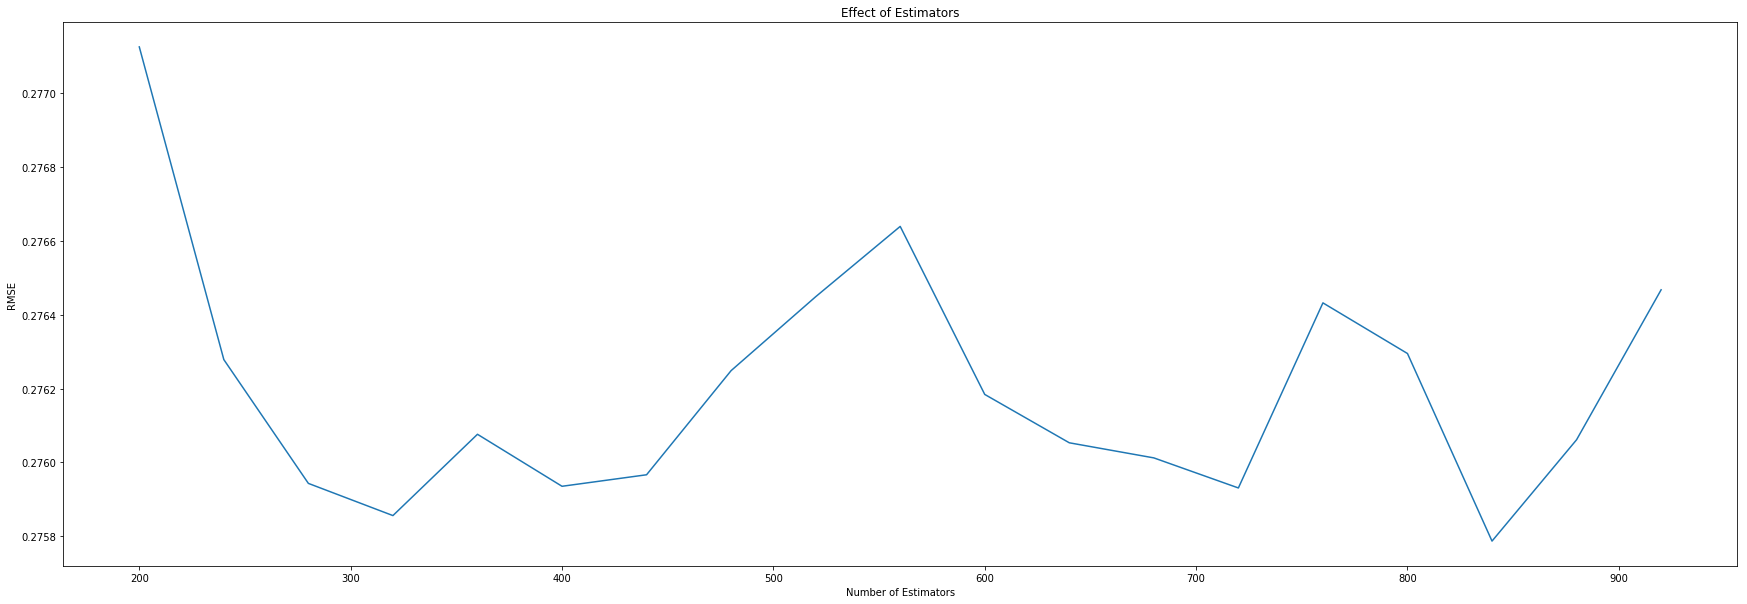

In [20]:
estimators = np.arange(200, 930, 40) #850 #880


model=RandomForestRegressor()

rmse_scores = []
for n in estimators:
    model.set_params(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=n, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
    model.fit(X_train, y_train)
    predictions=model.predict(X_test)
    rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

plt.figure(figsize=(30,10))
plt.title("Effect of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.plot(estimators, rmse_scores)

### Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
XG_grid = {"learning_rate":[0.01,0.05,0.1],
           "n_estimators":[600],
           "silent":[True],
           "n_jobs":[-1],
           "min_child_weight":[1,3],
           "max_depth":[4,6],
           "booster":['gbtree'],
           "gamma":[0.01,0.1],
           "colsample_bytree":[0.8],
          "subsample":[0.75,0.85]}

In [23]:
import time
start = time.clock()


XG=XGBRegressor()

XG_Boost = GridSearchCV(estimator=XG,
                        param_grid=XG_grid,
                        n_jobs=-1,
                        cv=4,
                        scoring="neg_mean_squared_error",
                        verbose=50)


XG_Boost.fit(X,Y)

end = time.clock()
end - start

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   52.7s
[Paralle

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:  8.6min
[Paralle

685.6748358

In [24]:
# cv_results = XG_Boost.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print(np.sqrt(-mean_score), params)

In [25]:
# XGBoost Regression
rmse = make_scorer(mean_sq_error,greater_is_better=True)
outcome_var = 'price'
model = XG_Boost.best_estimator_
predictor_var = all_variable
regression_model(model, main_train, predictor_var, outcome_var)

CV 0 Score:0.28537
CV 1 Score:0.29053
CV 2 Score:0.30411
CV 3 Score:0.29754
CV 4 Score:0.28717
Average RMSE Cross-Validation Score : 0.293


In [26]:
# XG_Boost1=XG_Boost.best_estimator_
XG_Boost1=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85, verbosity=1)

XG_Boost1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85, verbosity=1)

In [27]:
predictions=XG_Boost1.predict(X_test)

In [28]:
#RMSE
print(np.sqrt(metrics.mean_squared_error(y_test,predictions)))

0.278729401270455


## Feature Importance

### Random Forest

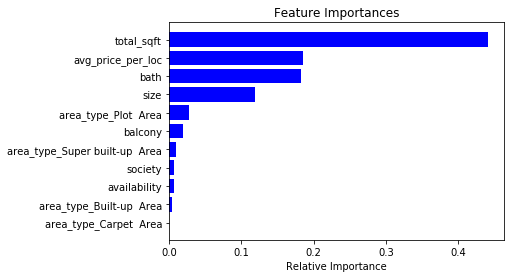

In [29]:
features = X_train.columns
importances = rf1_main.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [30]:
from xgboost import plot_importance

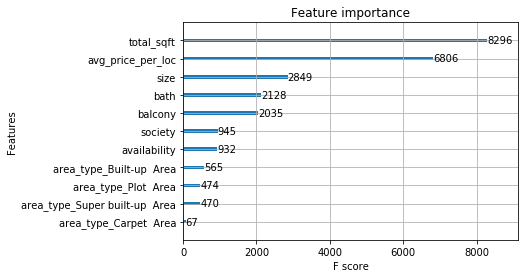

In [31]:
plot_importance(XG_Boost1)

## Recursive Feature Elimination

In [32]:
from sklearn.feature_selection import RFECV

### Random Forest

In [33]:
RFE = RFECV(rf1_main, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=27,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=260, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [34]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [35]:
selected_feature_rf = dict(zip(X_train.columns,RFE.support_))

selected_rf = []
for k,v in selected_feature_rf.items():
    if (v==True):
        selected_rf.append(k)

In [36]:
selected_rf

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']

### XGBoost

In [37]:
RFE = RFECV(XG_Boost1, step=3, cv=3, n_jobs=-1,
            scoring="neg_mean_squared_error", verbose=50)

RFE.fit(X=X_train, y=y_train)

RFECV(cv=3,
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0.01,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85, verbosity=1),
   n_jobs=-1, scoring='neg_mean_squared_error', step=3, verbose=50)

In [38]:
RFE.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [40]:
selected_feature_xgb = dict(zip(X_train.columns,RFE.support_))

selected_xgb = []
for k,v in selected_feature_xgb.items():
    if (v==True):
        selected_xgb.append(k)

In [41]:
selected_xgb

['availability',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony',
 'avg_price_per_loc',
 'area_type_Built-up  Area',
 'area_type_Carpet  Area',
 'area_type_Plot  Area',
 'area_type_Super built-up  Area']